In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os 
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv


## Loading and checking data

In [2]:
df = pd.read_csv('/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv')
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [4]:
df['class'].value_counts()

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64

In [5]:
df['class'] = [0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df['class']]

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


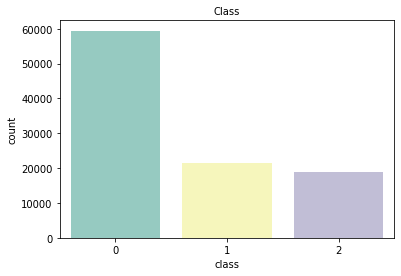

In [6]:
sns.countplot(df['class'], palette='Set3')
plt.title('Class', fontsize = 10)
plt.show()

## Detecting and deleting Outliers

In [7]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(df)

In [8]:
x_score = clf.negative_outlier_factor_

outlier_score = pd.DataFrame()
outlier_score['score'] = x_score

# drop the rows that have negative outlier factor less than -1.5
threashold2 = -1.5
filter2 = outlier_score['score'] < threashold2
outlier_index = outlier_score[filter2].index.tolist()

In [9]:
len(outlier_index)

15257

In [10]:
df.drop(outlier_index, inplace=True)

## Feature Selection

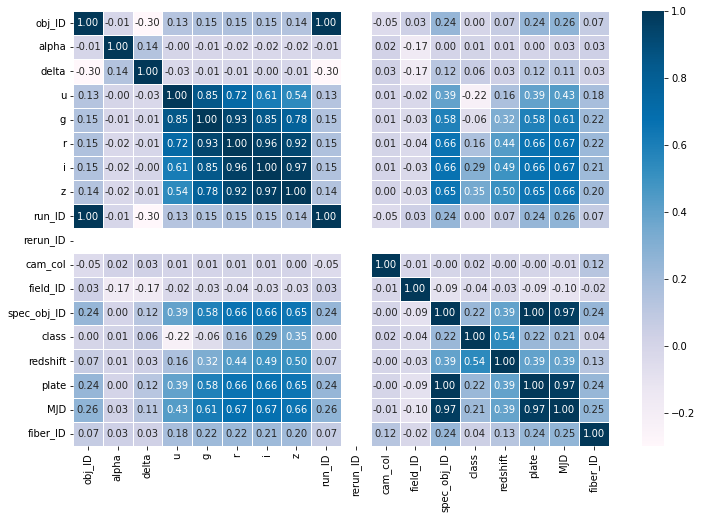

In [11]:
# using corelation
import seaborn as sns
f, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap='PuBu', annot=True, linewidths=0.5, fmt='.2f', ax=ax)
plt.show()

In [12]:
corr = df.corr()
corr['class'].sort_values()

u             -0.222790
g             -0.058177
field_ID      -0.037530
run_ID         0.000259
obj_ID         0.000261
alpha          0.008190
cam_col        0.017757
fiber_ID       0.037327
delta          0.058944
r              0.160671
MJD            0.214430
spec_obj_ID    0.224716
plate          0.224717
i              0.294092
z              0.349727
redshift       0.541682
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

In [13]:
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1)

## Dealing with imbalanced data 

In [14]:
# using SMOTE (Synthetic Minority Oversampling Technique)
from imblearn.over_sampling import SMOTE
from collections import Counter

In [15]:
X = df.drop(['class'], axis=1)
y = df.loc[:, 'class'].values

In [16]:
sm = SMOTE()
print('Original class distribution %s', Counter(y))
X, y = sm.fit_resample(X, y)
print('Resampled class distribution %s', Counter(y))

Original class distribution %s Counter({0: 50695, 1: 17890, 2: 16158})
Resampled class distribution %s Counter({0: 50695, 2: 50695, 1: 50695})


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


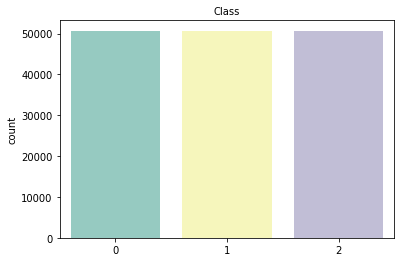

In [17]:
sns.countplot(y, palette='Set3')
plt.title('Class', fontsize=10)
plt.show()

## Data Scaling

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report

from yellowbrick.classifier import ConfusionMatrix, ClassPredictionError, ROCAUC
from yellowbrick.style import set_palette

## Train/Test Split

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

## SVM

In [21]:
svm_clf = svm.SVC(kernel='rbf', C = 1, random_state=0)
svm_clf.fit(x_train, y_train)
preds = svm_clf.predict(x_test)
score = svm_clf.score(x_test, y_test)
svm_score = np.mean(score)

print('Accuracy : %.3f' % (svm_score))

Accuracy : 0.971


### Visualizing the confusion matrix 

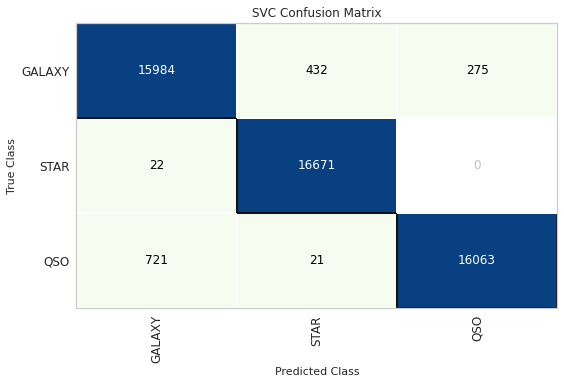

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [22]:
classes = ['GALAXY', 'STAR', 'QSO']

svm_cm = ConfusionMatrix(svm_clf, classes=classes, cmap='GnBu')
svm_cm.fit(x_train, y_train)
svm_cm.score(x_test, y_test)
svm_cm.show()

### Classification Report

In [23]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     16691
           1       0.97      1.00      0.99     16693
           2       0.98      0.96      0.97     16805

    accuracy                           0.97     50189
   macro avg       0.97      0.97      0.97     50189
weighted avg       0.97      0.97      0.97     50189



### ROC Curve

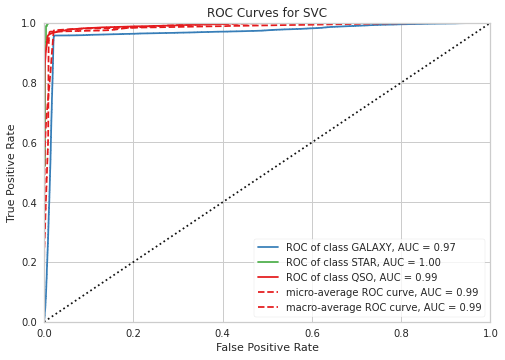

<AxesSubplot:title={'center':'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [24]:
visualizer = ROCAUC(svm_clf, classes=classes)

set_palette('bold')

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

### Class Prediction Error

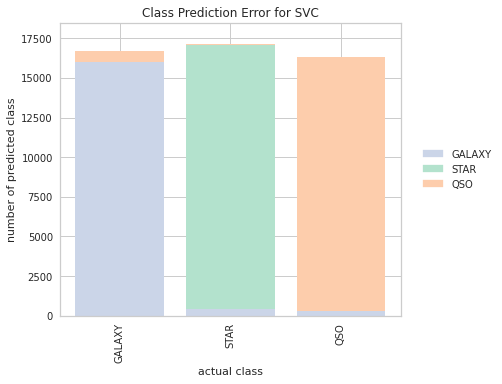

<AxesSubplot:title={'center':'Class Prediction Error for SVC'}, xlabel='actual class', ylabel='number of predicted class'>

In [25]:
visualizer = ClassPredictionError(svm_clf, classes=classes)
set_palette('pastel')

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

## Random Forest

In [26]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)
preds = rf_clf.predict(x_test)
score = rf_clf.score(x_test, y_test)
rf_score = np.mean(score)

print('Accuracy : %.3f' %(rf_score))

Accuracy : 0.984


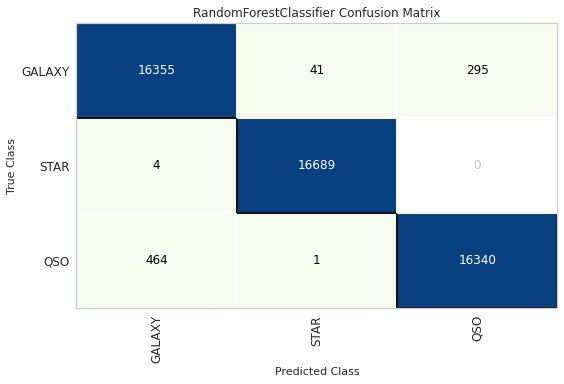

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [27]:
rf_cm = ConfusionMatrix(rf_clf, classes=classes, cmap='GnBu')
rf_cm.fit(x_train, y_train)
rf_cm.score(x_test, y_test)
rf_cm.show()

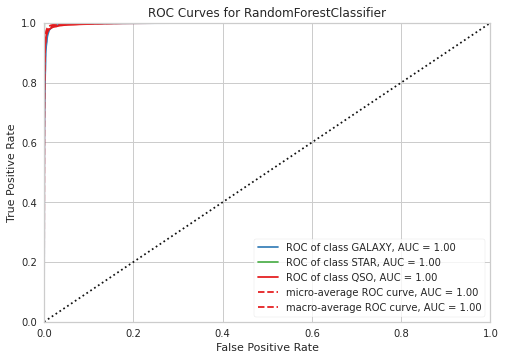

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [28]:
visualizer = ROCAUC(rf_clf, classes = classes)
set_palette('bold')

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

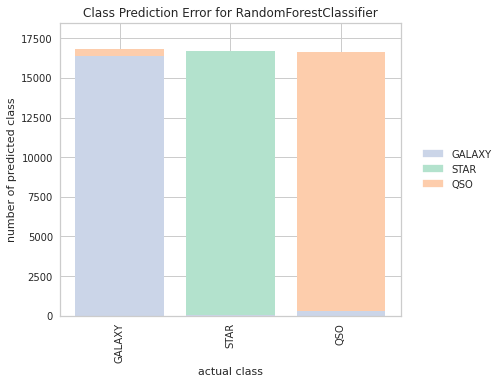

<AxesSubplot:title={'center':'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [29]:
visualizer = ClassPredictionError(rf_clf, classes = classes)
set_palette('pastel')

visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.show()

## On Average , Random Forest performed better than SVM